# Autoencoders

Los autoencoders son redes neuronales que aprenden sobre un mismo set de datos, y pueden usarse para reducir su dimensionalidad. Esta semana seguimos trabajando con el dataset de MNIST.  Vamos a ver como aprender y cómo usar estas redes, y el ejercicio abierto es que veas la capacidad de reducir dimensionalidad para visualizar.  

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_openml



In [2]:
mnist = fetch_openml('mnist_784', version=1, as_frame=True)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
from sklearn.model_selection import train_test_split
#Tomamos el dataset y lo dividimos en X (los pixeles) e y (el número que es). 
#Recordemos que las imágenes son 28x28 = 784 pixeles
X, y = mnist['data'], mnist['target']
X_sample = X[60000:]
y_sample = y[60000:]

### Para dividir en train  - test 
X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample, test_size=0.3, random_state=23)


<Axes: >

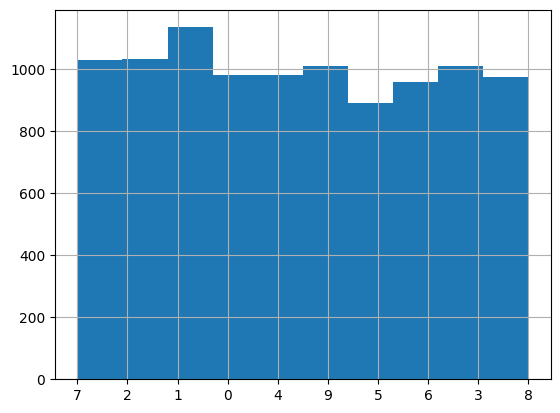

In [4]:
#Si bien los datos no están completamente balanceados, hay una buena mezcla de cada número en el dataset.
y_sample.hist()

<BarContainer object of 784 artists>

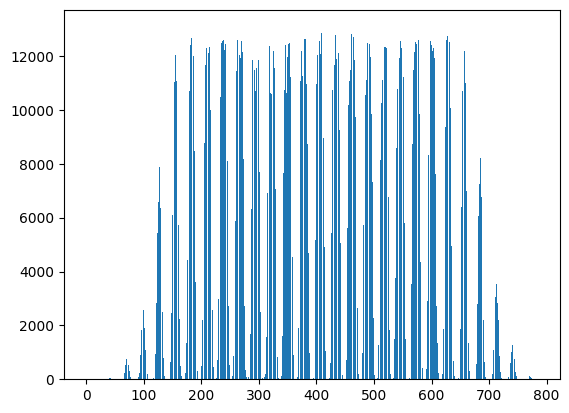

In [5]:
### Había quedado pendiente: un plot de la varianza de cada dimensión
plt.bar(np.arange(len(X_sample.columns)),X_sample.var())

Un aspecto bien importante, es que las redes autoencoders suelen trabajar mejor cuando podemos estandarizar los datos. 

In [6]:
### También vamos a estandarizar los datos en X
from sklearn.preprocessing import StandardScaler


sc = StandardScaler()
X_std = sc.fit_transform(X_sample)
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

In [7]:
X_std[0]

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -1.00005000e-02, -1.00005000e-02, -1.00005000e-02,
       -1.39737990e-02, -1.89315247e-02, -2.31843010e-02, -3.60728861e-02,
       -3.92619154e-02, -3.80269994e-02, -3.90143887e-02, -3.46046778e-02,
       -2.57765396e-02, -2.09733754e-02, -2.17809993e-02, -1.44984527e-02,
       -1.18807892e-02,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  

## Reduciendo a 5 dimensiones, autoencoder

Vamos a ver ahora como usamos un autoencoder para reducir nuestra dimensionalidad. Nuestro primer modelo es el más simple: una primera capa recibe un input de tamaño *num_dimensiones* y lo lleva a 5 neuronas. Luego esas 5 neuronas son "decodificadas" en un dataset con *num_dimensiones*.

Como esto es un autoencoder, vamos a separar conceptualmente las capas en dos. 
- una capa encoder que reduce la dimensionalidad
- una capa decoder que toma la dimensionalidad reducida y la devuelve a todas las dimensiones. 

La gracia es que podemos entrenar el autoencoder comparando los datos con los datos que fueron codificados y luego decodificados.

In [8]:
from tensorflow import keras

num_dimensiones = len(X_sample.columns)

#### Sequential es un modelo en keras que simplemente va concatenando las capas, 
#### las neuronas del final de una capa son las del principio de otra

#### keras.layers.Dense es una capa donde todas las neuronas están conectadas las unas a las otras

#### armamos el encoder: el input conectado a 5 neuronas
encoder = keras.models.Sequential([
    keras.layers.Dense(5, input_shape=[num_dimensiones]),
])

#### armamos el dencoder: esas 5 neuronas luego se conectan a todas las dimensiones del input 
decoder = keras.models.Sequential([
    keras.layers.Dense(num_dimensiones, input_shape=[5]),
])

#### y ahora concatenamos encoder y decoder
autoencoder = keras.models.Sequential([encoder, decoder])

#### compile lo deja listo para aprender. 
#### Para comparar el resultado del autoencoder y el dataset original 
#### usamos el clásico Mean Squared Error (a eso se le llama "loss")
#### Para entrenar usamos StochasticGradientDescent, con un alfa de 0.1 

autoencoder.compile(loss='mse', optimizer = keras.optimizers.SGD(learning_rate=0.1))

#### El entrenamiento toma los datos originales, los codifica/decodifica en vectores de la misma 
#### dimensión y los compara con los datos originales. 
#### Esto por 100 épocas, y para validar usamos el set de test. 
#### Para no perder tiempo, decidimos que debe parar si la métrica del MSE no mejora en 10 épocas. 

history = autoencoder.fit(X_train_std,X_train_std, epochs=100,validation_data=(X_test_std,X_test_std),
                         callbacks=[keras.callbacks.EarlyStopping(patience=10)])
                         
#### Finalmente, para codificar solo llamamos al método predict de la parte de encoder. 
X_auto = encoder.predict(X_std)

2024-10-15 17:49:39.722377: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-15 17:49:41.918738: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-15 17:49:43.363718: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-15 17:49:43.653004: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-15 17:49:43.710913: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-15 17:49:44.590945: I tensorflow/core/platform/cpu_feature_gu

Epoch 1/100


2024-10-15 17:49:53.294362: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 21952000 exceeds 10% of free system memory.
2024-10-15 17:49:53.302318: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 21952000 exceeds 10% of free system memory.


219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.8599 - val_loss: 5.4028
Epoch 2/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.8713 - val_loss: 5.3780
Epoch 3/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.8372 - val_loss: 5.3448
Epoch 4/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.8427 - val_loss: 5.3194
Epoch 5/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7587 - val_loss: 5.2976
Epoch 6/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7232 - val_loss: 5.2804
Epoch 7/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7001 - val_loss: 5.2690
Epoch 8/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6741 - val_loss: 5.2612
Epoch 9/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6841 - val_loss: 5.2560
Epoch 10/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6813 - val_loss: 5.2522
Epoch 11/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6841 - val_loss: 5.2492
Epoch 12/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

In [9]:
X_auto

array([[-4.380753  , -0.20930114, -5.2374806 ,  2.0497098 , -2.401461  ],
       [ 3.194425  ,  8.601458  ,  9.806052  , -4.7125626 , -1.3350602 ],
       [-5.092676  ,  4.7467904 , -2.2331994 , -5.113067  , -0.41818038],
       ...,
       [ 1.668603  , -0.3462938 , -5.9983945 ,  0.27854764,  0.908656  ],
       [-3.998729  , -3.1829572 , -2.6165366 , -5.1164813 ,  1.4926149 ],
       [10.630365  , -6.9404297 ,  3.736921  , -5.6659603 , -3.6126857 ]],
      dtype=float32)

## Probando cuál enfoque de reducción es mejor de forma indirecta: viendo qué dataset sirve más para clasificación. 

Pero como saber si esta codificación sirve de algo? 
Una posibilidad es probarlo de forma indirecta: ejecutando algún tipo de tarea de aprendizaje sobre estos datos, y comparando los resultados. 
Aquí, comparamos con la tarea de clasificar los números de MNIST usando RandomForest. Vamos a comparar el resultado de usar RandomForest en el todo, usando PCA, y usando estos modelos de autoencoders. 

Partimos por el original: 

In [10]:
from sklearn import tree
from sklearn.model_selection import cross_val_score

clf = tree.DecisionTreeClassifier()

np.mean(cross_val_score(clf, X_std, y_sample, cv=5, scoring='accuracy'))


0.7915

Ahora para el dataset transformado con autoencoder

In [11]:
np.mean(cross_val_score(clf, X_auto, y_sample, cv=5, scoring='accuracy'))


0.6342

Y finalmente para la decomposicion con PCA

In [12]:
from sklearn.decomposition import PCA

pca = PCA(n_components=5)
X_pca = pca.fit_transform(X_std) 

In [13]:
np.mean(cross_val_score(clf, X_pca, y_sample, cv=5, scoring='accuracy'))


0.6334

### Mejores autoencoders, ¿podremos acercarnos más al acuracy del dataset original?

Un primer enfoque puede ser agregar más capas a la red neuronal. Acá abajo agregamos dos capas adicionales tanto en el encoder con el decoder: pasamos de *num_dimensiones* a 200 neuronas, luego a 50 y luego a 5, y lo mismo para decodificar. 

In [14]:
### Modelo mas profundo

encoder = keras.models.Sequential([
    keras.layers.Dense(200, input_shape=[num_dimensiones]),
    keras.layers.Dense(50),
    keras.layers.Dense(5),
])

decoder = keras.models.Sequential([
    keras.layers.Dense(50, input_shape=[5]),
    keras.layers.Dense(200),
    keras.layers.Dense(num_dimensiones),
])

autoencoder = keras.models.Sequential([encoder, decoder])
autoencoder.compile(loss='mse', optimizer = keras.optimizers.SGD(learning_rate=0.1))

history = autoencoder.fit(X_train_std,X_train_std, epochs=100,validation_data=(X_test_std,X_test_std),
                         callbacks=[keras.callbacks.EarlyStopping(patience=10)])
                         
X_auto_deep = encoder.predict(X_std)

Epoch 1/100


/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-10-15 17:50:38.300819: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 21952000 exceeds 10% of free system memory.
2024-10-15 17:50:38.311283: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 21952000 exceeds 10% of free system memory.


219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.8463 - val_loss: 5.4253
Epoch 2/100
  1/219 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.7753

219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7798 - val_loss: 5.3389
Epoch 3/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7375 - val_loss: 5.2848
Epoch 4/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6945 - val_loss: 5.2615
Epoch 5/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6639 - val_loss: 5.2466
Epoch 6/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6661 - val_loss: 5.2372
Epoch 7/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6488 - val_loss: 5.2332
Epoch 8/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6322 - val_loss: 5.2268
Epoch 9/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6859 - val_loss: 5.2236
Epoch 10/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6586 - val_loss: 5.2196
Epoch 11/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6711 - val_loss: 5.2178
Epoch 12/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6691 - val_loss: 5.2151
Epoch 13/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/ste

In [15]:
np.mean(cross_val_score(clf, X_auto_deep, y_sample, cv=5, scoring='accuracy'))


0.6372

## Autoencoders con activación no lineal

Un segundo enfoque, y lo más clásico en la práctica, es agregar una activación no lineal al final de cada capa. En este caso usamos la función Scaled Exponential Linear Unit (SELU). 

In [16]:
encoder = keras.models.Sequential([
    keras.layers.Dense(200, input_shape=[num_dimensiones],activation='selu'),
    keras.layers.Dense(50,activation='selu'),
    keras.layers.Dense(5,activation='selu'),
])

decoder = keras.models.Sequential([
    keras.layers.Dense(50, input_shape=[5],activation='selu'),
    keras.layers.Dense(200,activation='selu'),
    keras.layers.Dense(num_dimensiones,activation='selu'),
])

autoencoder = keras.models.Sequential([encoder, decoder])
autoencoder.compile(loss='mse', optimizer = keras.optimizers.SGD(learning_rate=0.1))

history = autoencoder.fit(X_train_std,X_train_std, epochs=100,validation_data=(X_test_std,X_test_std),
                         callbacks=[keras.callbacks.EarlyStopping(patience=10)])
                         
X_auto_deep_relu = encoder.predict(X_std)

Epoch 1/100


/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.8797 - val_loss: 5.3075
Epoch 2/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7767 - val_loss: 5.2573
Epoch 3/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7545 - val_loss: 5.2256
Epoch 4/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7375 - val_loss: 5.2075
Epoch 5/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7338 - val_loss: 5.1994
Epoch 6/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6852 - val_loss: 5.1946
Epoch 7/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6835 - val_loss: 5.1910
Epoch 8/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6928 - val_loss: 5.1893
Epoch 9/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7050 - val_loss: 5.1874
Epoch 10/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6828 - val_loss: 5.1856
Epoch 11/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6741 - val_loss: 5.1850
Epoch 12/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

In [17]:
np.mean(cross_val_score(clf, X_auto_deep_relu, y_sample, cv=5, scoring='accuracy'))


0.7186

## Ejercicio 1

Experimenta con distintos modelos que reduzcan a dos dimensiones. Visualiza y compara como lo hicimos en la tarea 3, con las reducciones con PCA y T-SNE, tomando como referencia las clases reales (los números que representan cada fila). 